<a href="https://colab.research.google.com/github/wasef-c/emotion_rec/blob/main/Bi_DirectionalLSTM_Performance_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bi-Directional LSTM - Emotion Recognition**

The following notebook assesses the CNN before hyperparamater tuning and after to decide on the best model

**Make sure you make your X and Y Datasets from the noteboook data-preprocessing here:**

https://colab.research.google.com/drive/1dD9sspV9kJ0HjqX2sTjH-3DFNpLKY8QY?usp=sharing

**Make sure you make train and optimize hyperpamaters from this notebook**

https://colab.research.google.com/drive/1dD9sspV9kJ0HjqX2sTjH-3DFNpLKY8QY?usp=sharing

In [ ]:
# Dependencies
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import gc
import time
from tqdm import tqdm, tqdm_notebook; tqdm.pandas() # Progress bar
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split

# Machine Learning
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec

# from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

from tensorflow.keras.layers import (Dense, Bidirectional, ELU,
                          Dropout, LeakyReLU, Conv1D, BatchNormalization)
from keras.models import Sequential
# from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


# Set seed for reproducability
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

t_start = time.time()

In [ ]:
save_directory = '/content/drive/MyDrive/MASC/Saved_Sets/008'

X_test = np.load(os.path.join(save_directory, 'X_Te008.npy'))
Y_test = np.load(os.path.join(save_directory, 'Y_Te008.npy'))


In [ ]:
def splitIntoChunks(mel_spec,win_size,stride):
    t = mel_spec.shape[1]
    num_of_chunks = int(t/stride)
    chunks = []
    for i in range(num_of_chunks):
        chunk = mel_spec[:,i*stride:i*stride+win_size]
        if chunk.shape[1] == win_size:
            chunks.append(chunk)
    return np.stack(chunks,axis=0)

In [ ]:
import torch
import torch.nn as nn
# BATCH FIRST TimeDistributed layer
class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)
        # squash samples and timesteps into a single axis
        elif len(x.size()) == 3: # (samples, timesteps, inp1)
            x_reshape = x.contiguous().view(-1, x.size(2))  # (samples * timesteps, inp1)
        elif len(x.size()) == 4: # (samples,timesteps,inp1,inp2)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3)) # (samples*timesteps,inp1,inp2)
        else: # (samples,timesteps,inp1,inp2,inp3)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3),x.size(4)) # (samples*timesteps,inp1,inp2,inp3)

        y = self.module(x_reshape)

        # we have to reshape Y
        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(1))  # (samples, timesteps, out1)
        elif len(x.size()) == 4:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2)) # (samples, timesteps, out1,out2)
        else:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2),y.size(3)) # (samples, timesteps, out1,out2, out3)
        return y

In [ ]:
# ''' https://github.com/Data-Science-kosta/Speech-Emotion-Classification-with-PyTorch/blob/master/notebooks/stacked_cnn_attention_lstm.ipynb'''
class HybridModel(nn.Module):
    def __init__(self,num_emotions, dropout_rate, hidden_size, lstm_layers):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            TimeDistributed(nn.Conv2d(in_channels=1,
                                   out_channels=16,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(16)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=2, stride=2)),
            TimeDistributed(nn.Dropout(p=dropout_rate)),
            # 2. conv block
            TimeDistributed(nn.Conv2d(in_channels=16,
                                   out_channels=32,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(32)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=dropout_rate)),
            # 3. conv block
            TimeDistributed(nn.Conv2d(in_channels=32,
                                   out_channels=64,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(64)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=dropout_rate))
        )
        # LSTM block

        # hidden_size = 64
        self.lstm = nn.LSTM(input_size=1024,hidden_size=hidden_size,bidirectional=True, batch_first=True, num_layers=lstm_layers)

        self.dropout_lstm = nn.Dropout(p=0.4)
        self.attention_linear = nn.Linear(2*hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM
        # Linear softmax layer
        self.out_linear = nn.Linear(2*hidden_size,num_emotions)

        # hidden_size = 32
        # self.lstm = nn.LSTM(input_size=1024,hidden_size=hidden_size,bidirectional=False, batch_first=True)
        # ''' # ADDED FOR GPU
        # self.lstm.flatten_parameters() '''

        # self.dropout_lstm = nn.Dropout(p=0.4)
        # self.attention_linear = nn.Linear(hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM
        # # Linear softmax layer
        # self.out_linear = nn.Linear(hidden_size,num_emotions)
    def forward(self,x):
        conv_embedding = self.conv2Dblock(x)
        conv_embedding = torch.flatten(conv_embedding, start_dim=2) # do not flatten batch dimension and time
        lstm_embedding, (h,c) = self.lstm(conv_embedding)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        # lstm_embedding (batch, time, hidden_size*2)
        batch_size,T,_ = lstm_embedding.shape
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_embedding[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),dim=-1)
        attention = torch.bmm(attention_weights_norm,lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)
        output_logits = self.out_linear(attention)
        output_softmax = nn.functional.softmax(output_logits,dim=1)
        return output_logits, output_softmax, attention_weights_norm


In [ ]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

In [ ]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

In [ ]:
EMOTIONS  = {
    0: 'neutral',
    1: 'happy',
    2: 'sad',
    3: 'angry',
    4: 'fearful',
    5: 'disgust',
}
LOAD_PATH = r'/content/drive/MyDrive/MASC/Saved_Models'

original_model = HybridModel(num_emotions=6, dropout_rate=0.3, hidden_size= 64,lstm_layers=1 )
optimized_model = HybridModel(num_emotions=6, dropout_rate=0.3, hidden_size= 64,lstm_layers=1 )
original_model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn_attention_lstm_model8.pt')))
optimized_model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn_attention_lstm_model_8_c.pt')))


<All keys matched successfully>

In [ ]:
def splitIntoChunks(mel_spec,win_size,stride):
    t = mel_spec.shape[1]
    num_of_chunks = int(t/stride)
    chunks = []
    for i in range(num_of_chunks):
        chunk = mel_spec[:,i*stride:i*stride+win_size]
        if chunk.shape[1] == win_size:
            chunks.append(chunk)
    return np.stack(chunks,axis=0)

In [ ]:
# get chunks
from sklearn.preprocessing import StandardScaler


save_directory = r'/content/drive/MyDrive/MASC/Saved_Sets/008'

X_test = np.load(os.path.join(save_directory, 'X_Te008.npy'))
Y_test = np.load(os.path.join(save_directory, 'Y_Te008.npy'))



mel_test_chunked = []
for mel_spec in X_test:
    chunks = splitIntoChunks(mel_spec, win_size=128,stride=64)
    mel_test_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))

X_test = np.stack(mel_test_chunked,axis=0)
X_test = np.expand_dims(X_test,2)
print('Shape of X_test: ',X_test.shape)

scaler = StandardScaler()

b,t,c,h,w = X_test.shape
X_test = np.reshape(X_test, newshape=(b,-1))
scaler.fit(X_test)

X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b,t,c,h,w))

Number of chunks is 1
Shape of X_test:  (3614, 1, 1, 87, 128)


In [ ]:
import torch
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score, cohen_kappa_score, matthews_corrcoef

# Assuming the validate function returns predictions in a format compatible with scikit-learn
validate = make_validate_fnc(original_model,loss_fnc)


X_test_tensor = torch.tensor(X_test, device='cpu').float()
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long, device='cpu')
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)


test_loss, test_acc, predictions = validate(X_test_tensor, Y_test_tensor)

# Calculate F1 score
f1 = f1_score(Y_test_tensor.cpu().numpy(), predictions.cpu().numpy(), average='weighted')

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(Y_test_tensor.cpu().numpy(), predictions.cpu().numpy())

# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(Y_test_tensor.cpu().numpy(), predictions.cpu().numpy())

print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')
print(f'F1 score is {f1:.2f}')
print(f'Cohen\'s Kappa is {kappa:.2f}')
print(f'Matthews Correlation Coefficient is {mcc:.2f}')

Test loss is 1.014
Test accuracy is 60.02%
F1 score is 0.59
Cohen's Kappa is 0.51
Matthews Correlation Coefficient is 0.52


In [ ]:

validate = make_validate_fnc(optimized_model,loss_fnc)

test_loss_opt, test_acc_opt, predictions_opt = validate(X_test_tensor,Y_test_tensor)

# Calculate F1 score
f1_opt = f1_score(Y_test_tensor.cpu().numpy(), predictions_opt.cpu().numpy(), average='weighted')

# Calculate Cohen's Kappa
kappa_opt = cohen_kappa_score(Y_test_tensor.cpu().numpy(), predictions_opt.cpu().numpy())

# Calculate Matthews Correlation Coefficient
mcc_opt = matthews_corrcoef(Y_test_tensor.cpu().numpy(), predictions_opt.cpu().numpy())

print(f'Test loss is {test_loss_opt:.3f}')
print(f'Test accuracy is {test_acc_opt:.2f}%')
print(f'F1 score is {f1_opt:.2f}')
print(f'Cohen\'s Kappa is {kappa_opt:.2f}')
print(f'Matthews Correlation Coefficient is {mcc_opt:.2f}')

Test loss is 1.160
Test accuracy is 60.38%
F1 score is 0.60
Cohen's Kappa is 0.52
Matthews Correlation Coefficient is 0.52


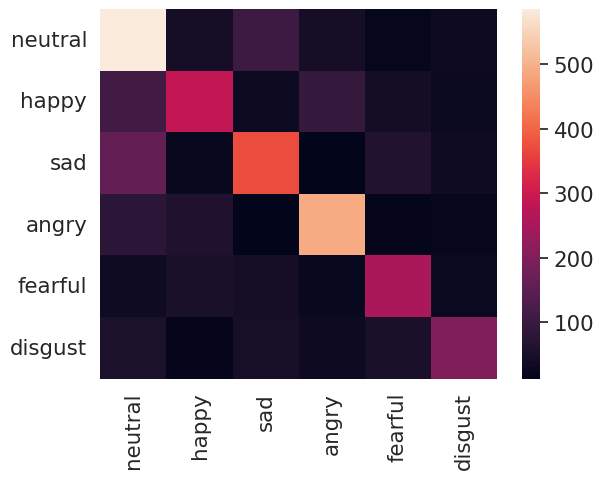

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions_opt)
names = [EMOTIONS[ind] for ind in range(0,6)]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=False, annot_kws={"size": 16}) # font size
plt.show()